# Training a Classifier

- The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

- If you are running this tutorial on Windows or MacOS and encounter a BrokenPipeError or RuntimeError related to multiprocessing, try setting the num_worker of `torch.utils.data.DataLoader()` to 0.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

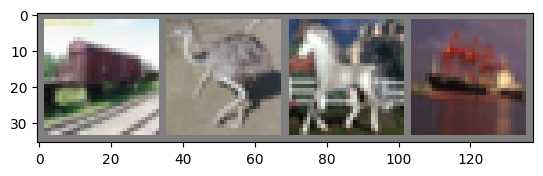

truck bird  horse ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# Get some randome training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print the labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define Loss function and optimizer


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [6]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of inputs, labels
        inputs, labels = data

        optimizer.zero_grad()   # zero the parameter gradients
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i%2000 == 1999 :     # print every 2000th mini batches
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.249
[1,  4000] loss: 1.911
[1,  6000] loss: 1.696
[1,  8000] loss: 1.612
[1, 10000] loss: 1.536
[1, 12000] loss: 1.472
[2,  2000] loss: 1.405
[2,  4000] loss: 1.380
[2,  6000] loss: 1.349
[2,  8000] loss: 1.327
[2, 10000] loss: 1.294
[2, 12000] loss: 1.242
Finished Training


In [7]:
# save our trained model
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

## Test the network on the test data


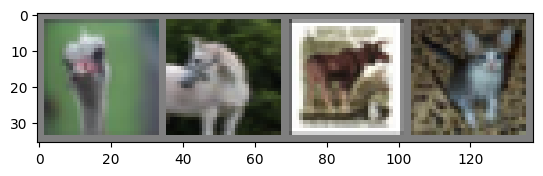

bird  horse deer  cat  


In [8]:
# Get some randome training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print the labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
# load the saved model
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [10]:
outputs = net(images)

- The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:



In [11]:
_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  bird  dog   frog  bird 


In [12]:
# Let us look how the network perform on the whole dataset
correct = 0
total = 0

# since we are not training, we don't need to calculate the gradient for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on 10000 test images: {100 * correct//total}")

Accuracy of the network on 10000 test images: 56


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 52.1 %
Accuracy for class: car   is 71.9 %
Accuracy for class: bird  is 55.2 %
Accuracy for class: cat   is 39.3 %
Accuracy for class: deer  is 27.3 %
Accuracy for class: dog   is 39.7 %
Accuracy for class: frog  is 72.5 %
Accuracy for class: horse is 59.6 %
Accuracy for class: ship  is 80.9 %
Accuracy for class: truck is 65.5 %


## Training on GPU


In [14]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps:0


In [15]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

- Remember that you will have to send the inputs and targets at every step to the GPU too:



In [16]:
inputs, labels = data[0].to(device), data[1].to(device)